In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as spy
import functions as f
import pynndescent as pynn
import gillespie as g
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad

# Here, we illustrate illustrate Fokker-Planck diffusion maps using simple use cases

## Example 1: A single Gaussian distribution. This distribution is generated by an Ornstein-Uhlenbeck process with additive noise. We will see how both sampling directly from a Gaussian and simnulating a O-U process lead to the same diffusion map. For additive noise, this case can be solved analytically. The resulting diffusion maps are given in terms of Hermite polynomials, which we will also show. These diffusion maps are unique up to a sign, and so they may appear flipped relative to one another

In [40]:
nFeats=10
cov=np.random.random(size=nFeats)*(.5)
mean = np.zeros(nFeats)
cov[0]=10 #we need a sufficiently large spectral gap to obseve the Hermites
cov=np.diag(cov)
X=np.random.multivariate_normal(mean, cov, size=2000)

I=pynn.NNDescent(X, n_neighbors=30)
ind,dist=I.query(X,k=15)
nn = f.nn_graph_directed(ind, dist)

nn = nn + nn.T

K = f.getTransitionMatrix(nn)
dMap, eVals = f.getDiffMap(K)
specGap = [eVals[i]-eVals[i+1] for i in range(len(eVals)-1)]


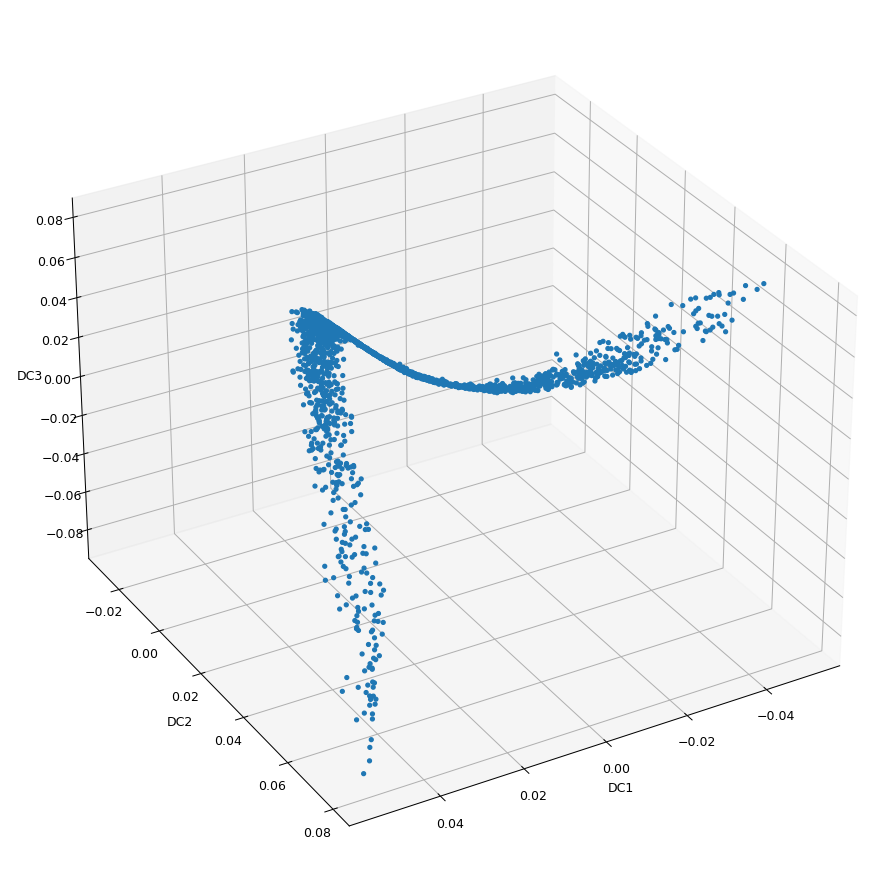

In [41]:
elev = 30
azim = 60
f.plot_diffmap(dMap, azim = azim, elev = elev)

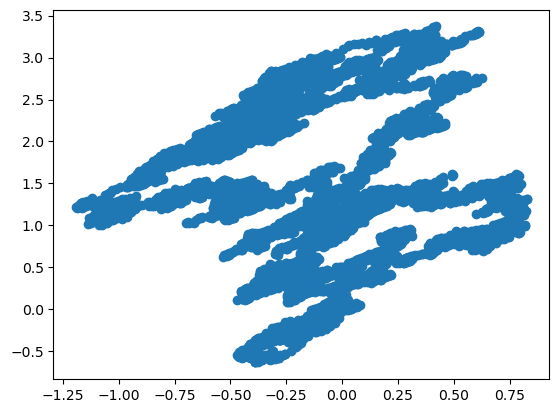

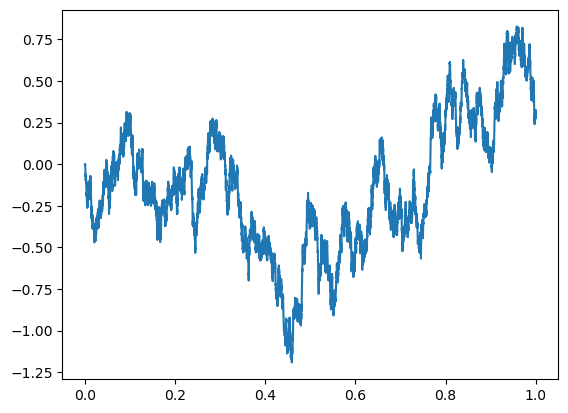

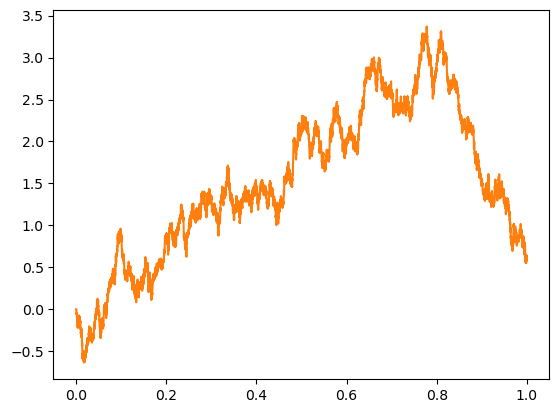

In [42]:
np.random.seed(None)
A = np.random.rand(10,10)
B = np.random.rand(10,10)*10**(-2)
gamma=np.zeros(shape = 10)

T=1000
t = np.linspace(0,1,10000, dtype = np.float128)
OU_params = f.OUParams(alpha=A, gamma=gamma, beta = B )
X = f.OU_process_mv(t,OU_params, single_source = False )
plt.scatter(X[0,:],X[1,:])
plt.show()
plt.plot(t,X[0,:])
plt.show()
plt.plot(t,X[1,:], c= "C1")
plt.show()

In [43]:
I=pynn.NNDescent(X.T, n_neighbors=30)
ind,dist=I.query(X.T,k=15)
nn = f.nn_graph_directed(ind, dist)

nn = nn + nn.T

K = f.getTransitionMatrix(nn)
dMap, eVals = f.getDiffMap(K)
specGap = [eVals[i]-eVals[i+1] for i in range(len(eVals)-1)]

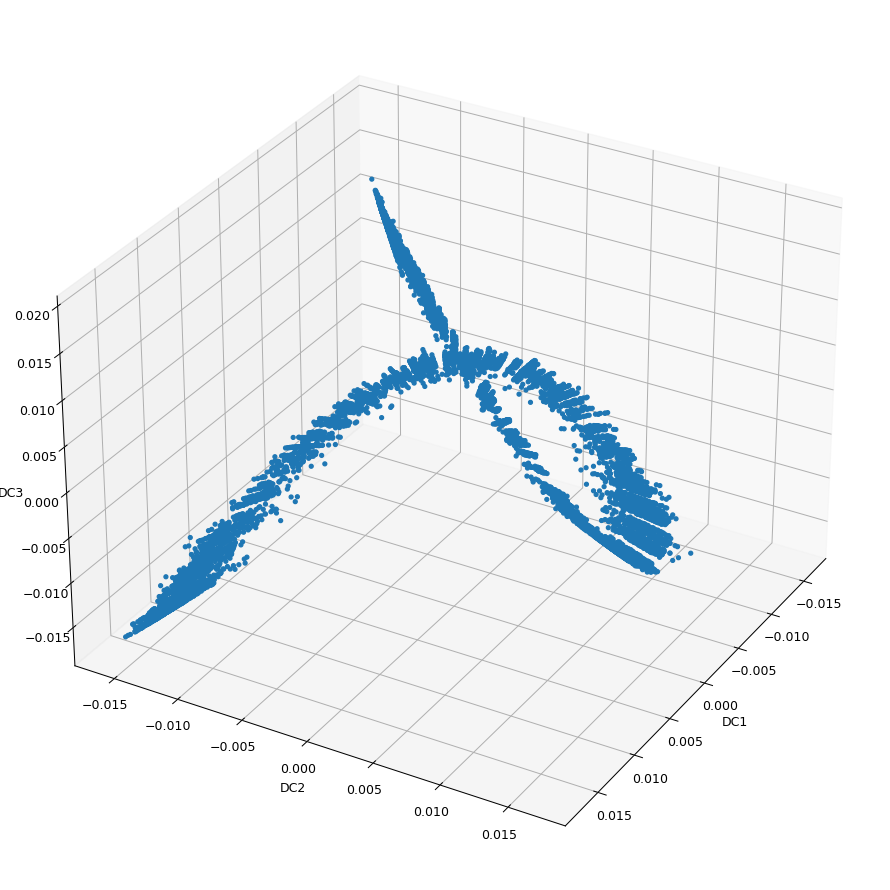

In [44]:
elev = 30
azim = 30
f.plot_diffmap(dMap, azim = azim, elev = elev)

In [45]:
grid = np.linspace(-1,1, 1000)
X = spy.special.hermite(1)*spy.special.hermite(0)
Y = spy.special.hermite(1)*spy.special.hermite(1)
Z = spy.special.hermite(1)*spy.special.hermite(2)
x = np.vstack([X(grid),Y(grid),Z(grid)]).T

/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


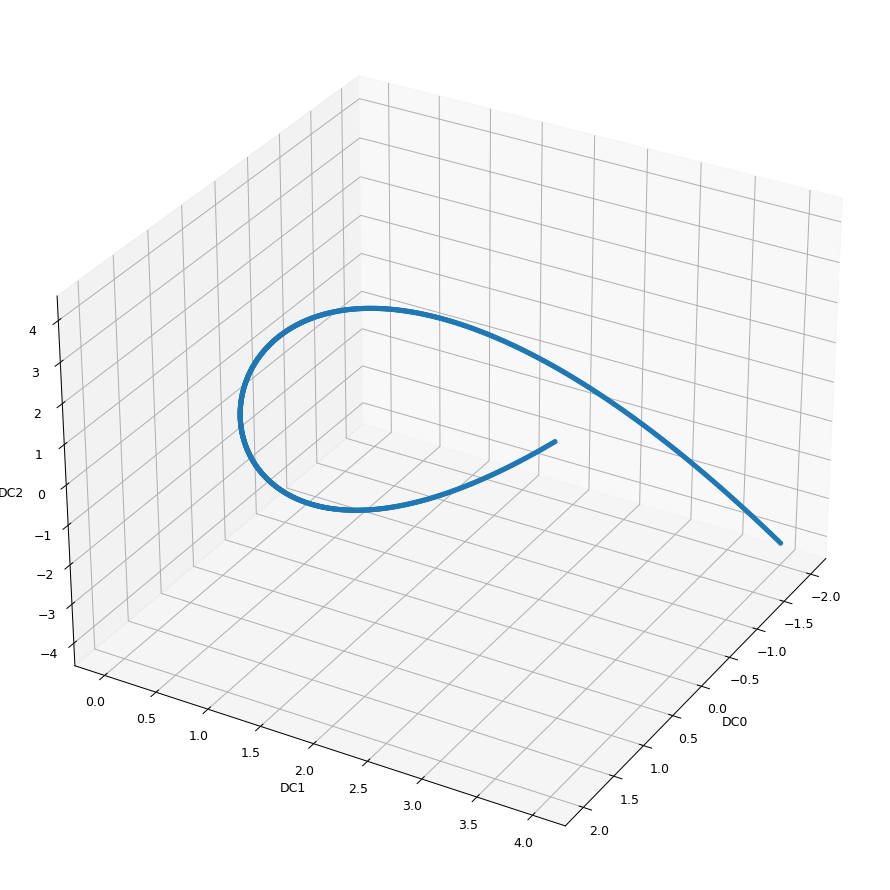

In [46]:
elev = 30
azim = 30
f.plot_diffmap(x, dim1 = 0, dim2 = 1, dim3 = 2, elev = elev, azim = azim)

## Now lets look at an example of 6 trajectories from two seperate Birth-Death processes

In [21]:
b1, d1 = 30, .5
b2, d2 = 50,1
b3, d3 = 30,2
b4, d4 = 13,.5
grid = np.linspace(0, 6, 1_000)
T = 6

propensities = [lambda x1, x2, x3, x4: b1,  # x1 birth 0 -> x1
                lambda x1, x2, x3, x4: d1*x1,  # x1 death x1 -> 0,
                lambda x1, x2, x3, x4 : b2,  # x2 birth, 0 -> x2
                lambda x1, x2, x3, x4: d2*x2, # x2 death x2 -> 0,
                lambda x1, x2, x3, x4: b3,
                lambda x1, x2, x3, x4: d3*x3,
                lambda x1, x2, x3, x4: b4,
                lambda x1, x2, x3, x4: d4*x4
               ]
                
stoichiometry = [[1, 0,0,0],  
                 [-1, 0, 0, 0 ],
                 [0, 1, 0, 0],
                 [0, -1, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0 ,-1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, -1]]

n_runs = 3
X = []
times = []
#initials = [[10,13,8,1], [45,35,12,66], [100,120,89,2]]
for i in range(n_runs):
    initial = np.random.randint(low = 10, high = 50, size = 4)  # x1,x2
#    initial = initials[i]
    t,xx = g.simulate(initial, propensities, stoichiometry, T)
    Xi = interp1d(t, xx, axis=0)
    X.append(Xi(grid))
    #times.append(t)
X = np.concatenate(X, axis = 0)

b1, d1 = 12, .5
b2, d2 = 120,1
b3, d3 = 160,2
b4, d4 = 1,.5

T = 6

propensities1 = [lambda x1, x2, x3, x4: b1,  # x1 birth 0 -> x1
                lambda x1, x2, x3, x4: d1*x1,  # x1 death x1 -> 0,
                lambda x1, x2, x3, x4: b2,  # x2 birth, 0 -> x2
                lambda x1, x2, x3, x4: d2*x2, # x2 death x2 -> 0,
                lambda x1, x2, x3, x4: b3,
                lambda x1, x2, x3, x4: d3*x3,
                lambda x1, x2, x3, x4: b4,
                lambda x1, x2, x3, x4: d4*x4
               ]
                
stoichiometry1 = [[1, 0,0,0],  
                 [-1, 0, 0, 0 ],
                 [0, 1, 0, 0],
                 [0, -1, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0 ,-1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, -1]]

n_runs = 3
X1 = []
times1 = []
#initials = [[10,13,8,1], [45,35,12,66], [100,120,89,2]]
for i in range(n_runs):
    initial = np.random.randint(low = 10, high = 50, size = 4)  # x1,x2
#    initial = initials[i]
    t,xx = g.simulate(initial, propensities, stoichiometry, T)
    Xi = interp1d(t, xx, axis=0)
    X1.append(Xi(grid))
#    times1.append(t)
X1 = np.concatenate(X1, axis = 0)

In [22]:
X = np.concatenate([X,X1])
x = X/X.sum(axis=1)[:,None]

In [23]:
I=pynn.NNDescent(x, n_neighbors=30)
ind,dist=I.query(x,k=15)
nn = f.nn_graph_directed(ind, dist)

nn = nn + nn.T

K = f.getTransitionMatrix(nn)
dMap, eVals = f.getDiffMap(K)
specGap = [eVals[i]-eVals[i+1] for i in range(len(eVals)-1)]

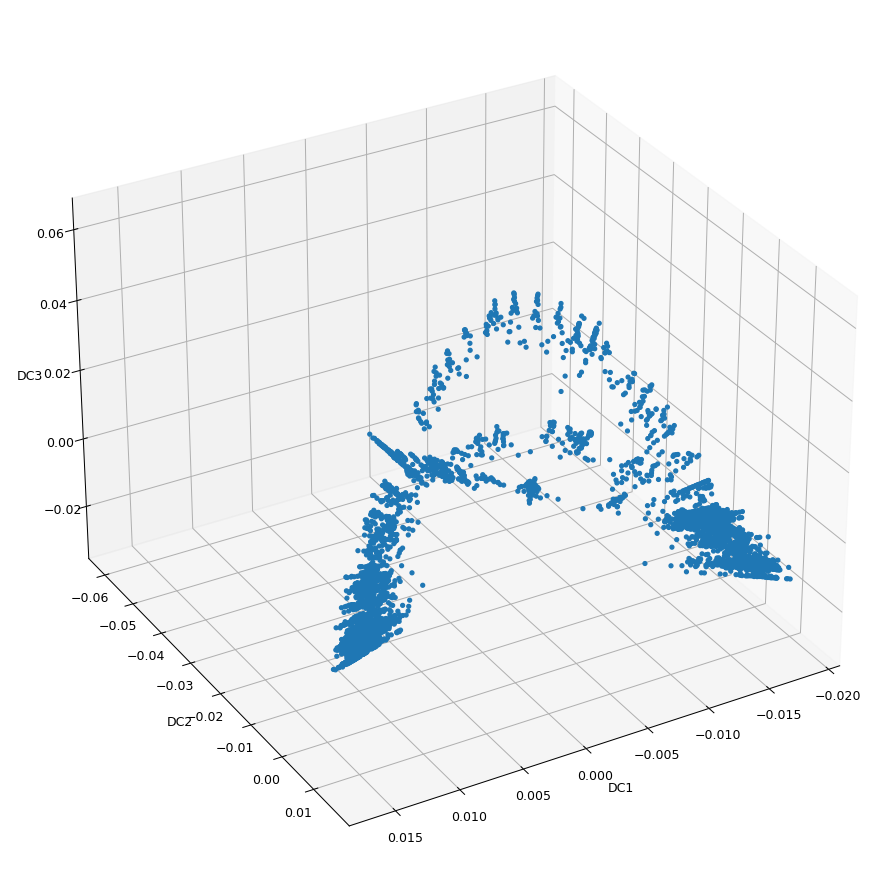

In [24]:
elev = 30
azim = 60
f.plot_diffmap(dMap, azim = azim, elev = elev)

#### Now it is not clear that there exists two identifiable equilbirum in this plot. To see it, we can do Kernel Density Estimation on the first three diffusion coordinates

In [25]:
from scipy.stats import gaussian_kde
density = gaussian_kde(dMap[:,1:4].T)
C = density(dMap[:,1:4].T)

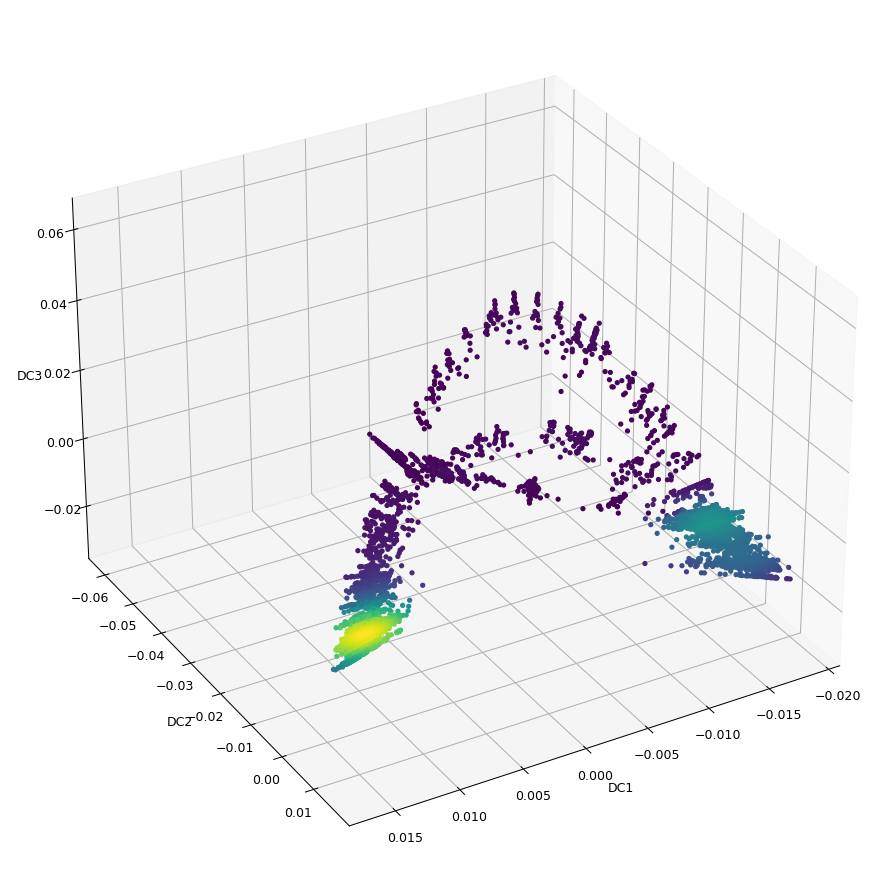

In [26]:
elev = 30
azim = 60
f.plot_diffmap(dMap, azim = azim, elev = elev, c= C)

### now we see that there are two distinct high density regions in the diffusion map corresponding to the two minima of of our simple model. 

## Lets look at a double well with orthogonal noise directions. This takes a long time to run and requires at least 100k data points to get reasonable diffusion maps. feel free to skip

In [27]:
def U(x,a,b,c,d = None):
    D=len(x)
    if d == None:
        d=D
    elif d > len(x):
        raise ValueError('d must be less than or equal to len(x)')
        
    U = (x[0]**2)*(a*x[0]**2 - b) + (b**2)/(4*a) 
    
    for i in range(0,d-1):
        U += .5*c[i]*(x[i] - x[i+1])**2
    return U
        
        
def grad_U(x,a,b,c,d = None):
    D=len(x)
    if d == None:
        d=D
    elif d > len(x):
        raise ValueError('d must be less than or equal to len(x)')
    out = []
    out.append(4*a*x[0]**3-2*b*x[0]-c[0]*(x[0]-x[1]))
    for k in range(1,d-1):
        out.append(-c[k-1]*(x[k-1]-x[k])+c[k]*(x[k]-x[k+1]))
        
    out.append(-c[d-2]*(x[d-2]-x[d-1]))
    
    for k in range(d,D):
        out.append(0)
    return np.array(out)
    

In [28]:
D=10
grid = [np.random.choice(np.linspace(0,3,300)) for i in range(D)]

In [50]:
T = 500
N = 200
D = 10
a = 1
b = 4
c=[4 for i in range(D-1)]
samp = np.zeros(((T+1)*N,D))
for n in range(N):
    dW = np.random.multivariate_normal(np.zeros(D), np.eye(D), size = T)
    beta = np.array([np.random.choice(np.linspace(.1,.0001,600)) for i in range(D)])
    X_traj = np.zeros((T+1,D))
    dt = .001
    x = [np.random.choice(np.linspace(-5,5,600)) for i in range(D)]                 
    X_traj[0,:] = x
    for i in range(T):
        dx = -grad_U(x,a,b,c)*dt + beta*dW[i]
        x = x + dx
        X_traj[i+1,:] = x
    samp[n*(T+1):(n+1)*(T+1),:]=X_traj

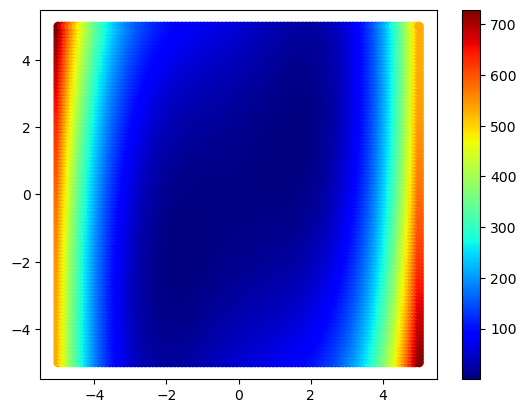

In [51]:
#visualize the potential
x = np.linspace(-5,5,100)
grid = np.meshgrid(x,x)

X = np.stack((grid[0], grid[1]), axis = -1)
X = X.reshape(10000,2)

U_out = []
for x in X:
    U_out.append(U(x,a,b,c))
    
colTraj = []
plt.scatter(X[:,0],X[:,1], c = U_out, cmap = 'jet')
plt.colorbar()

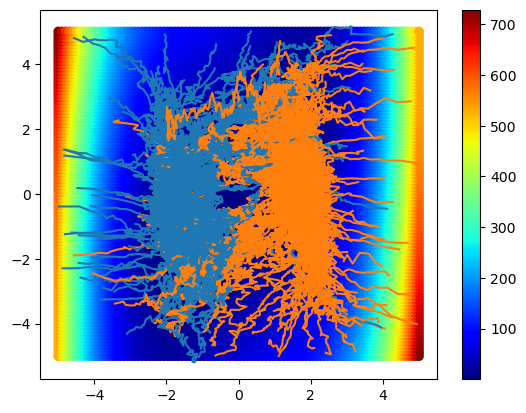

In [52]:
colTraj = []
plt.scatter(X[:,0],X[:,1], c = U_out, cmap = 'jet')
plt.colorbar()
dd = 0
for i in range(N):
    if samp[(i+1)*(T),0]<0:
        col='C0'
    else:
        col='C1'
    colTraj.extend([col for i in range(501)])
    plt.plot(samp[i*(T+1):(i+1)*(T+1),dd],samp[i*(T+1):(i+1)*(T+1),dd+1],  c = col)
plt.scatter([np.sqrt(b/(2*a)),-np.sqrt(b/(2*a))],[np.sqrt(b/(2*a)),-np.sqrt(b/(2*a))], c = 'red', s=500)
#plt.savefig('./2Dwell_figs/potential_example_multnoise.png')
plt.show()

In [53]:
I=pynn.NNDescent(samp, n_neighbors=30)
ind,dist=I.query(samp,k=15)
nn = f.nn_graph_directed(ind, dist)
nn = nn + nn.T

In [ ]:
T = f.getTransitionMatrix(nn)
dMap, eVals = f.getDiffMap(T)
specGap = [eVals[i]-eVals[i+1] for i in range(len(eVals)-1)]

In [ ]:
elev = 30
azim = 30
f.plot_diffmap(dMap, c = colTraj, elev = elev, azim = azim)

### Lets try a case with linear multiplicative noise. The first example comes from Jacobs' book Stochastic Processes for Physicists and is a coupled system. Not sure if this will generalize to more than 2 dimensions.The general Ornstein-Uhlenbeck system is 
$$ \Large d\vec{x} = F\vec{x}dt + G\vec{x}dW$$
### the exercise in the book takes G to be diagonal with the same coeffs, and F to be off diagonal with relative minus signs. For commuting matricies, the solution to the above is 
$$ \Large x(t) = e^{(F-\frac{1}{2}G^2)t + GW(t)}x(0) $$
### You obtain this by first diagonalizing the matricies, then changing variables to $y=\ln(x)$.

In [65]:
omega = .05
b = .001
F = np.zeros(shape = (10,10))
np.fill_diagonal(np.fliplr(F), [omega*(-1)**n for n in range(10)])
G = np.zeros(shape = (10,10))
np.fill_diagonal(G,[b for i in range(10)])
T = 1000
dW = f.get_dW(T)
W = np.cumsum(dW)
W = np.insert(W, 0, 0)[:-1]
t = np.linspace(0,10,T)
X = np.zeros(shape = (F.shape[0],T))
FF = F-.5*(G @ G)
X0 = np.array([.001 for i in range(10)])
for i,tt in enumerate(t):
    A = FF*tt + G*W[i]
    X0 = spy.linalg.expm(A) @ X0
    X[:,i] = X0

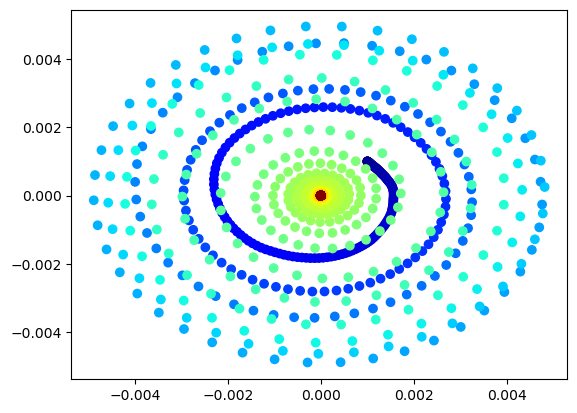

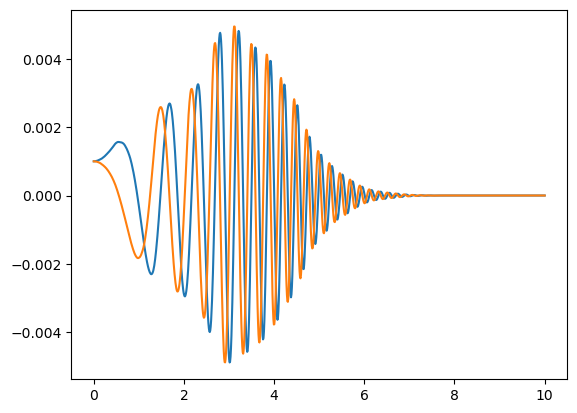

In [66]:
plt.scatter(X[0,:],X[1,:], c = t, cmap = 'jet')
plt.show()
plt.plot(t,X[0,:])
plt.plot(t,X[3,:], c= "C1")   

In [67]:
I=pynn.NNDescent(X.T, n_neighbors=30)
ind,dist=I.query(X.T,k=15)
nn = f.nn_graph_directed(ind, dist)
nn = nn + nn.T

In [68]:
T = f.getTransitionMatrix(nn)
dMap, eVals = f.getDiffMap(T)
specGap = [eVals[i]-eVals[i+1] for i in range(len(eVals)-1)]

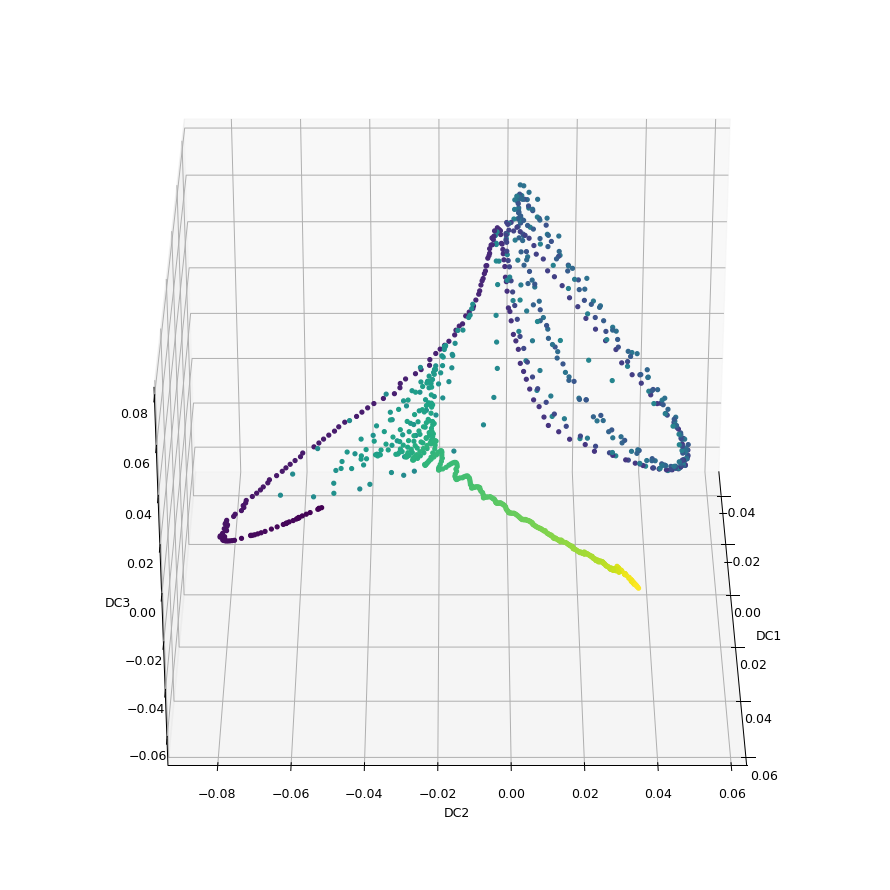

In [73]:
elev = 30
azim = 0
f.plot_diffmap(dMap, c = t, elev = elev, azim= azim)